## Прогнозирование количества вызовов такси

В нашем распоряжении имеются данные о заказах такси в аэропорт.  
В работе будет проведено исследование временного ряда и построены модели для прогноза количества заказов такси на следующий час.  
Результат работы моделе будет оцениваться метрикой RMSE.  
Приемлемым результатом будем считать значение RMSE меньше 48.

Количество заказов находистя в столбце 'num_orders'.

# 1. Подготовка

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
#from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

Сделаем индексы датой и преобразуем в формат datetime64

In [80]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [81]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


# 2. Анализ

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет

Проверим, в хронологическом ли порядке представлены данные

In [83]:
data.index.is_monotonic

True

Данные идут по порядку, по датам. В нашем распоряжении информация за 5 месяцев: с марта по август 2018 г.

In [84]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Построим график временного ряда

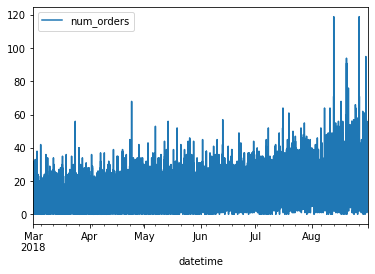

In [85]:
data.plot()
plt.show()

Выполним ресемлирование по одному часу и построим график

In [86]:
data = data.resample('1H').sum()

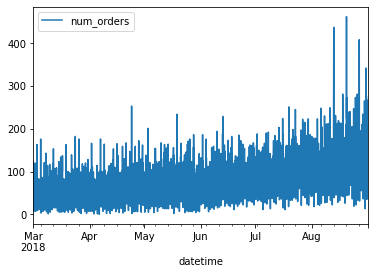

In [87]:
data.plot()
plt.show()

Сделаем ресемплирование по одному дню

In [88]:
data_1d = data.resample('1D').mean()

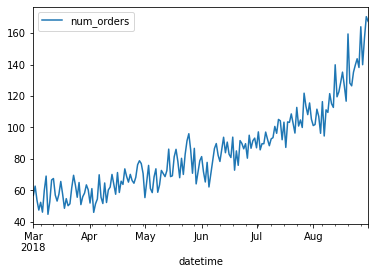

In [89]:
data_1d.plot()
plt.show()

Вычислим плавающее серднее и построим график.

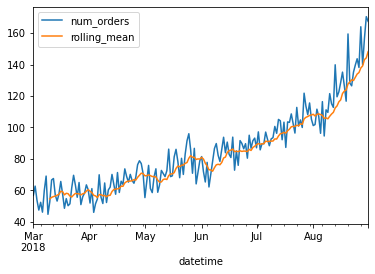

In [90]:
data_1d['rolling_mean'] = data_1d.rolling(10).mean()
data_1d.plot()
plt.show()

Заметно, что среднее количество заказов растет ближе к лету.

Вычислим тренд, сезонность и остатки.

In [91]:
decomposed = seasonal_decompose(data) # создаем объект Decompose

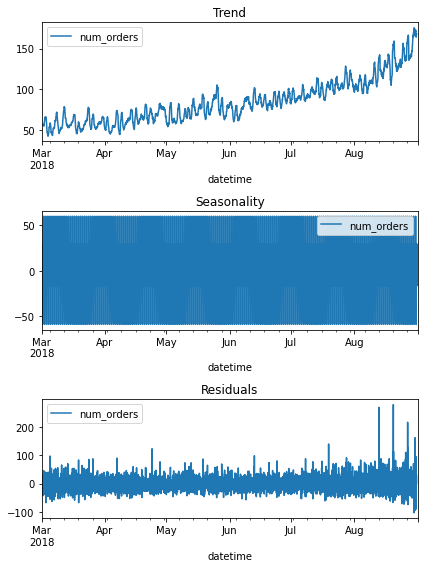

In [92]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По тренду также виден рост числа заказов при наступлении лета

Построим график сезонной составляющей за первые две недели апреля.

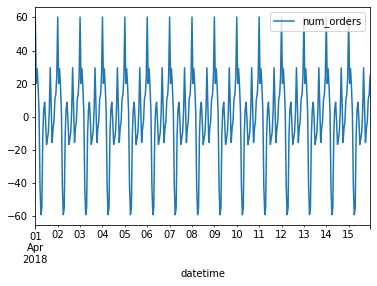

In [93]:
decomposed.seasonal['2018-04-01':'2018-04-15'].plot()
plt.show()

Увеличим масштаб, построим за несколько дней.

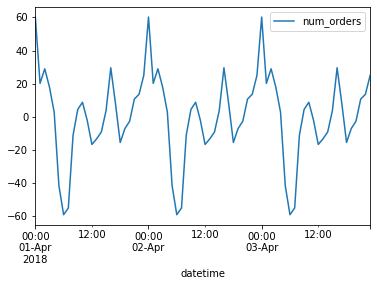

In [94]:
decomposed.seasonal['2018-04-01':'2018-04-3'].plot()
plt.show()

Из проведенного анализа можно сделать следующие выводы:  
 - хорошо заметен тренд: в течение 5 месяцев количество заказов растет, начиная с весны и достигает максимума летом;
 - присутствует зависимость количества заказов от времени суток. Ночью - меньше, днем - больше.

# 3. Обучение

Напишем функцию для создания дополнительных признаков временного ряда.

In [95]:
def make_features(data, max_lag, rolling_mean_size):

    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


Николай, полностью согласен. Не будем добавлять год, месяц и день.

In [96]:
make_features(data, 30, 10)

In [97]:
data.head(10)

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим из датасета пустые значения, образовавшиеся из-за временных сдвигов и введения дополнительных признаков.

In [98]:
data = data.dropna()

In [99]:
data.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,4,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,67.8
2018-03-02 07:00:00,7,4,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,62.8
2018-03-02 08:00:00,46,4,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.9
2018-03-02 09:00:00,45,4,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,50.2
2018-03-02 10:00:00,54,4,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,48.9


Разделим имеющиеся данные на обучающую и тестовую выборки.

In [100]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

Обозначим признаки и целевой признак.

In [101]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Обучим модель линейной регрессии.

In [102]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

Напишем функцию для определения важности признаков с использованием метода рекурсивного исключения признаков.

In [103]:
def rfe_select_features(X, y, estimator, num_features):
    rfe_selector = RFE(estimator=estimator, 
                       n_features_to_select=num_features, 
                       step=10, verbose=5)
    rfe_selector.fit(X, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    
    return rfe_feature

In [104]:
# полный спиов признаков
colnames = features_train.columns

# определим словарь для хранения уровня важности признаков
ranks = {}

# функция для создания словаря уровней важности
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

Проведем оценку важности признаков.

In [105]:
# останавливаемся, когда остался только один признак
rfe = RFE(model_lr, n_features_to_select=1, verbose=3)
rfe.fit(features_train, target_train)
ranks["RFE_LR"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 feature

In [106]:
# создадим датафрейм с признаками и значением importance

rfe_lr_df = pd.DataFrame(list(ranks['RFE_LR'].items()), columns= ['Feature','rfe_importance'])

all_ranks = rfe_lr_df

all_ranks = all_ranks.sort_values(by='rfe_importance', ascending=False)
all_ranks

,Feature,rfe_importance
0,dayofweek,1.00
24,lag_24,0.97
1,lag_1,0.94
23,lag_23,0.90
2,lag_2,0.87
26,lag_26,0.84
27,lag_27,0.81
3,lag_3,0.77
8,lag_8,0.74
28,lag_28,0.71


Обучим модель по 10 наиболе важным признакам.

In [107]:
all_ranks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 25
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Feature         32 non-null     object 
 1   rfe_importance  32 non-null     float64
dtypes: float64(1), object(1)
memory usage: 768.0+ bytes


In [108]:
all_ranks = all_ranks.reset_index()
all_ranks

,index,Feature,rfe_importance
0,0,dayofweek,1.00
1,24,lag_24,0.97
2,1,lag_1,0.94
3,23,lag_23,0.90
4,2,lag_2,0.87
5,26,lag_26,0.84
6,27,lag_27,0.81
7,3,lag_3,0.77
8,8,lag_8,0.74
9,28,lag_28,0.71


Создадим датасет, состоящий из названий столбцов наиболее важных признаков.

In [109]:
max_rank = all_ranks[all_ranks['Feature'].index <= 15]['Feature']

In [110]:
max_rank

0        dayofweek
1           lag_24
2            lag_1
3           lag_23
4            lag_2
5           lag_26
6           lag_27
7            lag_3
8            lag_8
9           lag_28
10           lag_4
11    rolling_mean
12           lag_7
13           lag_5
14          lag_11
15          lag_22
Name: Feature, dtype: object

In [112]:
features_train = features_train[max_rank]
features_test = features_test[max_rank]

Обучим линейную регрессию на этих признаках.

In [113]:
model_lr.fit(features_train, target_train)

LinearRegression()

In [122]:
predictions_lr = model_lr.predict(features_test)

In [123]:
rmse = mean_squared_error(target_test, predictions_lr, squared=False)
print(f'RMSE = {rmse} для линейной легрессии')

RMSE = 45.38564300271097 для линейной легрессии


Обучим модель XGBoost.

In [116]:
score_func = make_scorer(mean_squared_error, greater_is_better=False)

args = {'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'random_state': 128, 
        'n_estimators': 20,
        'max_depth': 3,
        'learning_rate': 0.03,   
        'n_jobs': 1
       }

model_xgb = xgb.XGBRegressor(**args)

params_opt = {'n_estimators': [100, 150, 200], 
              'max_depth': [2, 3, 4],
              'n_jobs': [1, 2, 3]
             }

gridSearchCV = GridSearchCV(estimator=model_xgb, 
                            param_grid=params_opt, 
                            scoring=score_func)

gridSearchCV.fit(features_train, target_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.03, max_delta_step=None,
                                    max_depth=3, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=20, n_jobs=1,
                                    num_parallel_tree=None, random_state=128,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
          

In [117]:
gridSearchCV.best_params_

{'max_depth': 4, 'n_estimators': 200, 'n_jobs': 1}

Обучим модель с этими парметрами.

In [118]:
model_xgb = xgb.XGBRegressor( 
    booster='gbtree',
    objective='reg:squarederror',
    random_state=128, 
    n_estimators=200,
    max_depth=4,
    n_jobs=1,
    learning_rate=0.03, 
            
)

model_xgb.fit(features_train, target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=1, num_parallel_tree=1, random_state=128,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [124]:
predictions_xgb = model_xgb.predict(features_test)

In [125]:
rmse = mean_squared_error(target_test, predictions_xgb, squared=False)
print(f'RMSE = {rmse} для XGBoost')

RMSE = 46.39366796590877 для XGBoost


Значение RMSE с использованием модели линейной регрессии составило: 45.39  
Значение RMSE с использованием модели XGBoost составило: 46.39
    

Построим графики факт/предсказание для обоих моделей в масштабе нескольких дней.

In [147]:
target_train.head()

datetime
2018-03-02 06:00:00    11
2018-03-02 07:00:00     7
2018-03-02 08:00:00    46
2018-03-02 09:00:00    45
2018-03-02 10:00:00    54
Freq: H, Name: num_orders, dtype: int64

In [191]:
# функция для создания датасета и построения графика сравнеия target_test и predictions

def test_predict_plot(target, prediction):
    d = {'target_test': target,
     'predictions_lr': predictions
    }
    data_compare = pd.DataFrame(data=d)
    plt.plot(data_compare['2018-08-22':'2018-08-24'])
    plt.show()

График предсказаний модельной регрессии и истинного значения количества заказов с 22 по 24 августа 2018 г.

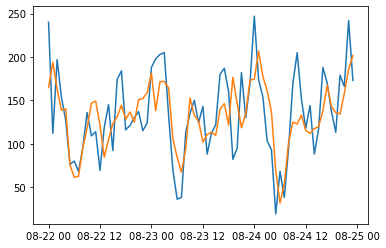

In [198]:
test_predict_plot(target_test, predictions_lr)

Такой же график для XGBoost

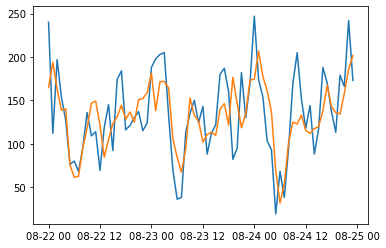

In [193]:
test_predict_plot(target_test, predictions_xgb)

## Вывод 

В работе было проанализировано поведение временного ряда. Выявлен тренд в количестве заказов, заключающийся в их увеличении с наступлением лета. Была выявлена закономерность в сезонности. В течение суток количество заказов изменяется: ночью меньше, днем - больше.  
Были обучены две модели для предсказания количества заказов в следующий час. Качество предсказания моделей оценивалось метрикой RMSE и получилось примерно одинаковым: 
 - XGBoost 46.06;
 - Linear Regression 46.65.

По визуализации видно, что модели работают практически идентично. Основные места "непопадания" у обеих моделей одинаковы: 22 числа в 12 часов, 23 в 00:00, 24-го в 12, 23 около 6 утра. Такие несоответствия по имеющимся данным предсказать не представляется возможным. Необходимо запрашивать дополнительную информацию и вносить ее в имеющийся набор данных для улучшения качества предсказаний моделей.